In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier


# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval


project = 'bionic-kiln-340418' # Project ID inserted based on the query results selected to explore
location = 'us-west1' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

print('Authenticated')

Authenticated


In [2]:
%load_ext google.colab.data_table

In [3]:
#!gcloud config set compute/region us-central1
#!gcloud config set compute/zone us-central1-a
!gcloud config list project

[core]
project (unset)

Your active configuration is: [default]


In [4]:
from google.cloud import bigquery

#Print your current data
for dataset in client.list_datasets():
  print(dataset.dataset_id)

california
gratitude_bot
iotlabdataset


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bionic-kiln-340418.iotlabdataset.ortho-data`
  ''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 310 rows


In [7]:
data = client.get_job('bquxjob_5faf3e07_184bd270cbd') # Job ID inserted based on the query results selected to explore
print(data.query)

SELECT * FROM `bionic-kiln-340418.iotlabdataset.ortho-data` 


In [8]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_4afda5d8_1850f6ba41f') # Job ID inserted based on the query results selected to explore
data = job.to_dataframe()
data

,pelvic_incidence,pelvic_tilt_numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,Normal


In [9]:
data.describe()

,pelvic_incidence,pelvic_tilt_numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [10]:
data.isnull().sum()


pelvic_incidence            0
pelvic_tilt_numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt_numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


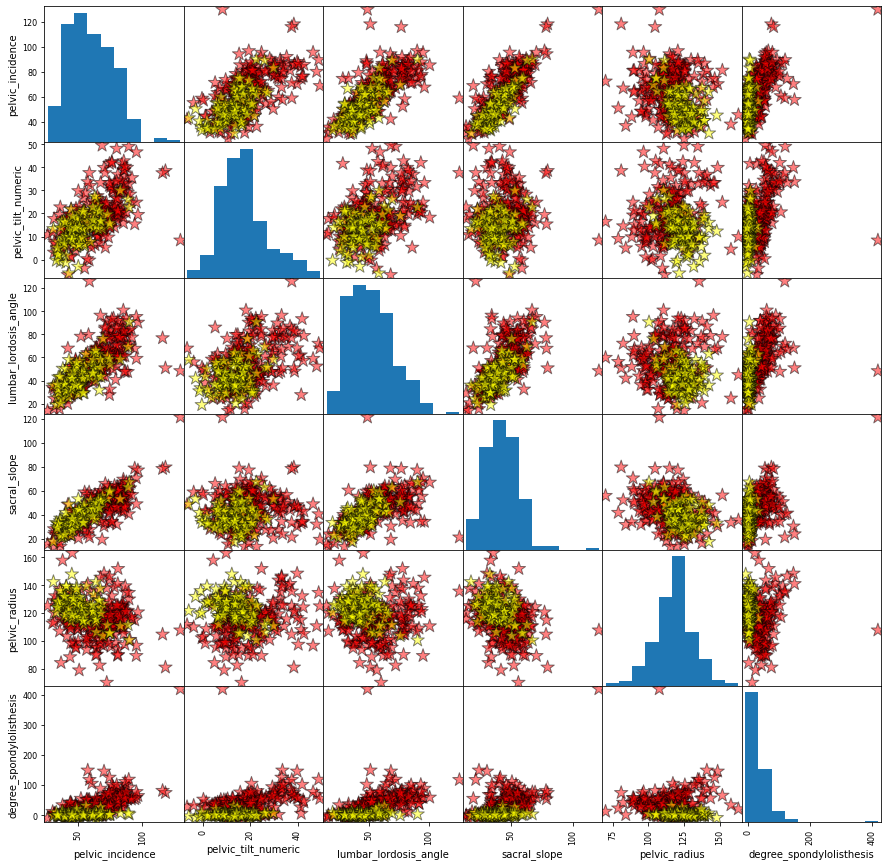

In [12]:
color_list = ['red' if i=='Abnormal' else 'yellow' for i in data.loc[:,'class']]
pd.plotting.scatter_matrix(data.loc[:, data.columns != 'class'],
                                       c=color_list,
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

Abnormal    210
Normal      100
Name: class, dtype: int64

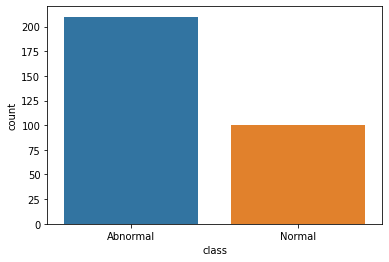

In [13]:
sns.countplot(x="class", data=data)
data.loc[:,'class'].value_counts()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Patients')

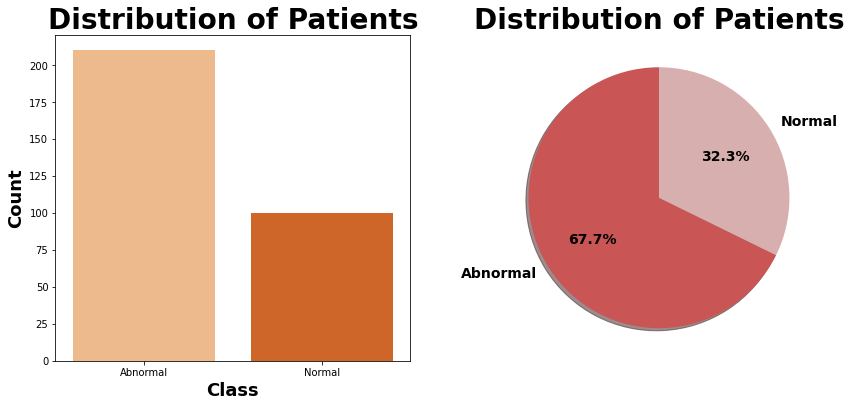

In [14]:
labels = data["class"].unique().tolist()
sizes = data["class"].value_counts().tolist()
colors = ["#C95555", "#D8AFAF"]
explode = (0, 0)
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.countplot(data["class"], palette="Oranges", ax=ax[0])
ax[0].set_title("Distribution of Patients", size=28, fontweight="bold")
ax[0].set_xlabel("Class", size=18, fontweight="bold")
ax[0].set_ylabel("Count", size=18, fontweight="bold")
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14, "fontweight" : "bold"}, colors=colors)
plt.title("Distribution of Patients", size=28, fontweight="bold")

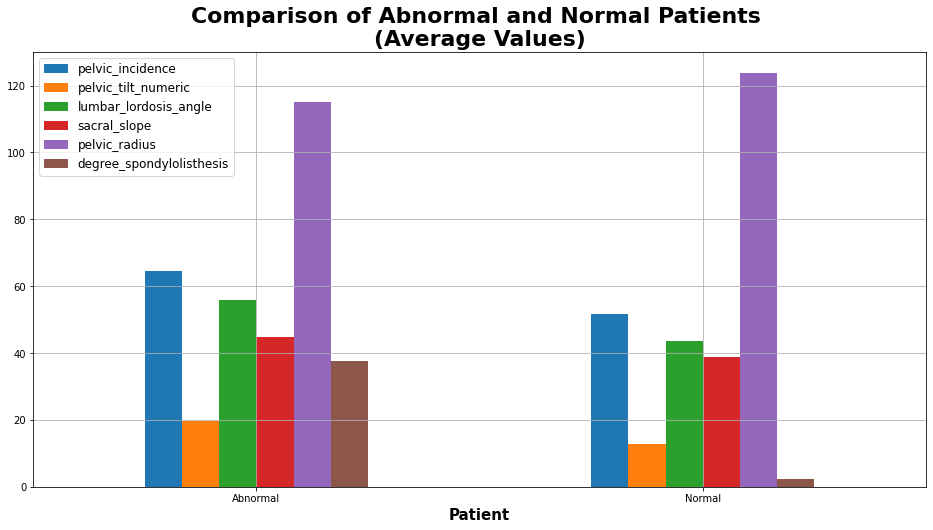

In [15]:
df_grouped = data.groupby("class").agg("mean")
df_grouped

df_grouped.plot.bar(rot=0, figsize=(16,8))
plt.title("Comparison of Abnormal and Normal Patients \n(Average Values)", fontsize=22, fontweight="bold")
plt.xlabel("Patient", fontsize=15, fontweight="bold")
plt.grid()
plt.legend(prop={"size":12})

We can see that the average degree spondylolisthesis value in abnormal patients is pretty higher than average the degree spondylolisthesis value in normal patients.


## Data Preprocessing 

In [16]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['class']

In [17]:
# Encoding categorical features
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

In [18]:
target_name = 'class'
data_target = data[target_name]
data = data.drop([target_name], axis=1)

In [19]:
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=1)

In [20]:
train.head(3)

,pelvic_incidence,pelvic_tilt_numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
67,75.649731,19.339799,64.148685,56.309932,95.903629,69.551303
283,48.995958,13.113820,51.873520,35.882137,126.398188,0.535472
122,80.074914,48.069531,52.403439,32.005383,110.709912,67.727316


In [21]:
test.head(3)

,pelvic_incidence,pelvic_tilt_numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
78,67.412538,17.442797,60.144640,49.969741,111.123970,33.157646
244,63.026300,27.336240,51.605017,35.690060,114.506608,7.439870
185,91.468741,24.508177,84.620272,66.960564,117.307897,52.623047


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 67 to 37
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          217 non-null    float64
 1   pelvic_tilt_numeric       217 non-null    float64
 2   lumbar_lordosis_angle     217 non-null    float64
 3   sacral_slope              217 non-null    float64
 4   pelvic_radius             217 non-null    float64
 5   degree_spondylolisthesis  217 non-null    float64
dtypes: float64(6)
memory usage: 11.9 KB


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 78 to 112
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          93 non-null     float64
 1   pelvic_tilt_numeric       93 non-null     float64
 2   lumbar_lordosis_angle     93 non-null     float64
 3   sacral_slope              93 non-null     float64
 4   pelvic_radius             93 non-null     float64
 5   degree_spondylolisthesis  93 non-null     float64
dtypes: float64(6)
memory usage: 5.1 KB


In [140]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=1)

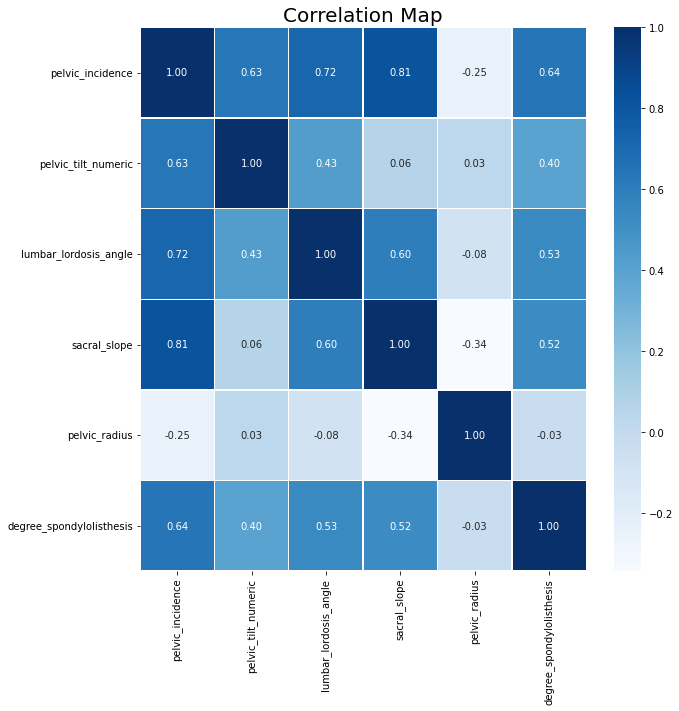

In [157]:
#correlation map
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, linewidth=".5", cmap="Blues", fmt=".2f", ax = ax)
plt.title("Correlation Map",fontsize=20)
plt.show()

## Tuning models and test for all features 

### Logistic Regression

In [26]:
# Logistic Regression
# all parameters not specified are set to their defaults

logreg_model = LogisticRegression()
logreg_model.fit(train, target)
acc_log = logreg_model.score(train, target)
acc_test_log = logreg_model.score(test, target_test)
print("Logistic_Regression_train_accuracy = ",acc_log)
print("Logistic_Regression_test_train_accuracy = ",acc_test_log)


Logistic_Regression_train_accuracy =  0.847926267281106
Logistic_Regression_test_train_accuracy =  0.8709677419354839


Text(24.0, 0.5, 'True')

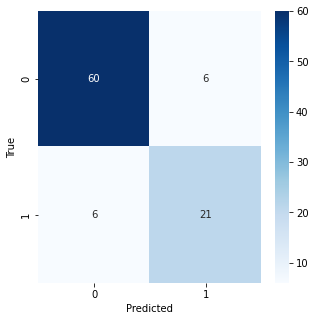

In [100]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_predict_lr = logreg_model.predict(test)
cm_lr = confusion_matrix(target_test, y_predict_lr)
plt.figure(figsize=(5,5))
sns.heatmap(cm_lr, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [99]:
print(classification_report(target_test, y_predict_lr))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        66
           1       0.78      0.78      0.78        27

    accuracy                           0.87        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.87      0.87      0.87        93



### Support Vector Machine(SVM) Classification


In [87]:
SVM_param_grid={
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'decision_function_shape': ['ovo', 'ovr']
}

In [88]:
svc_model = GridSearchCV(SVC(), SVM_param_grid).fit(train, target)


In [89]:
# Support Vector Machines
acc_svc = svc_model.score(train, target)
acc_test_svc = svc_model.score(test, target_test) 


print("SVM_train_accuracy = ",acc_log)
print("SVM_train_accuracy = ",acc_test_log)

SVM_train_accuracy =  0.847926267281106
SVM_train_accuracy =  0.8709677419354839


Text(24.0, 0.5, 'True')

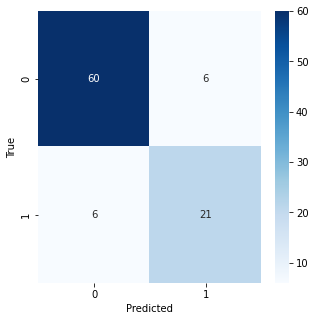

In [101]:
y_predict_svm = svc_model.predict(test)
cm_svm = confusion_matrix(target_test, y_predict_svm)
plt.figure(figsize=(5,5))
sns.heatmap(cm_svm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [102]:
print(classification_report(target_test, y_predict_svm))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        66
           1       0.78      0.78      0.78        27

    accuracy                           0.87        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.87      0.87      0.87        93



###  Linear SVC 

In [122]:
# Linear SVC

linear_svc_model = LinearSVC(dual=False)  # dual=False when n_samples > n_features.
linear_svc_model.fit(train, target)
acc_linear_svc = linear_svc_model.score(train, target)
acc_test_linear_svc = linear_svc_model.score(test, target_test) 

print("SVM_train_accuracy = ",acc_linear_svc)
print("SVM_train_accuracy = ",acc_test_linear_svc)

SVM_train_accuracy =  0.847926267281106
SVM_train_accuracy =  0.8602150537634409


Text(24.0, 0.5, 'True')

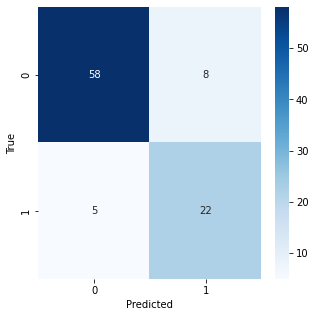

In [123]:
y_predict_linear_SVC = linear_svc_model.predict(test)
cm_linear_SVC = confusion_matrix(target_test, y_predict_linear_SVC)
plt.figure(figsize=(5,5))
sns.heatmap(cm_linear_SVC, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [124]:
print(classification_report(target_test, y_predict_linear_SVC))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        66
           1       0.73      0.81      0.77        27

    accuracy                           0.86        93
   macro avg       0.83      0.85      0.84        93
weighted avg       0.87      0.86      0.86        93



### k-Nearest Neighbors algorithm

In [29]:
knn_param_grid={
    'n_neighbors': range(2,30),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree','kd_tree','auto']
}

In [30]:
knn = GridSearchCV(KNeighborsClassifier(), knn_param_grid).fit(train, target)


In [31]:
# k-Nearest Neighbors algorithm

acc_knn = knn.score(train, target)
acc_test_knn = knn.score(test, target_test)

print("acc_knn_train_accuracy = ",acc_knn, knn.best_params_)
print("acc_test_knn_test_accuracy = ",acc_test_knn)

acc_knn_train_accuracy =  1.0 {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'distance'}
acc_test_knn_test_accuracy =  0.8172043010752689


Text(24.0, 0.5, 'True')

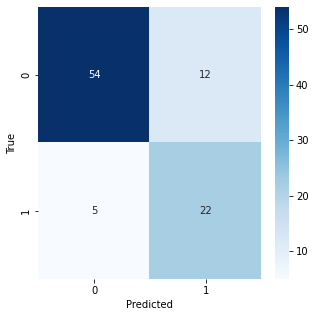

In [126]:
y_predict_KNN = knn.predict(test)
cm_KNN = confusion_matrix(target_test, y_predict_KNN)
plt.figure(figsize=(5,5))
sns.heatmap(cm_KNN, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [127]:
print(classification_report(target_test, y_predict_KNN))

              precision    recall  f1-score   support

           0       0.92      0.82      0.86        66
           1       0.65      0.81      0.72        27

    accuracy                           0.82        93
   macro avg       0.78      0.82      0.79        93
weighted avg       0.84      0.82      0.82        93



### Naive Bayes

In [32]:
# Naive Bayes does not have any Hyperparameters
gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = gaussian.score(train, target)
acc_test_gaussian = gaussian.score(test, target_test)

print("Naive_Bayes _accuracy = ",acc_gaussian)
print("Naive_Bayes _train_accuracy = ",acc_test_gaussian)


Naive_Bayes _accuracy =  0.7695852534562212
Naive_Bayes _train_accuracy =  0.8172043010752689


Text(24.0, 0.5, 'True')

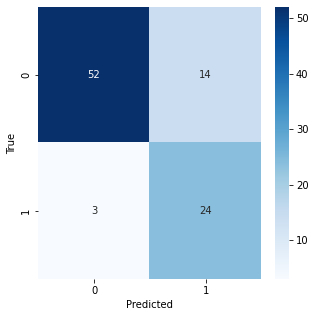

In [128]:
y_predict_gaussian = gaussian.predict(test)
cm_gaussian = confusion_matrix(target_test, y_predict_gaussian)
plt.figure(figsize=(5,5))
sns.heatmap(cm_gaussian, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [129]:
print(classification_report(target_test, y_predict_gaussian))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86        66
           1       0.63      0.89      0.74        27

    accuracy                           0.82        93
   macro avg       0.79      0.84      0.80        93
weighted avg       0.85      0.82      0.82        93



###  Decision Tree Classifier 

This model uses a Decision Tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

In [34]:
min_samples_split=np.arange(2,15,1)
min_samples_leaf=np.arange(1,15,1)
DT_param_grid={
    'criterion': ['gini', 'entropy'],
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': ['auto', 'sqrt']
}

In [35]:
# Decision Tree Classifier
decision_tree = GridSearchCV(DecisionTreeClassifier(), DT_param_grid).fit(train, target)

In [36]:
acc_decision_tree = decision_tree.score(train, target)
acc_test_decision_tree = decision_tree.score(test, target_test)

print("acc_decision_tree_train_accuracy = ",acc_decision_tree)
print("decision tree best params: ", decision_tree.best_params_)
print("acc_test_decision_tree_test_accuracy = ",acc_test_decision_tree)


acc_decision_tree_train_accuracy =  0.8986175115207373
decision tree best params:  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14}
acc_test_decision_tree_test_accuracy =  0.7419354838709677


Text(24.0, 0.5, 'True')

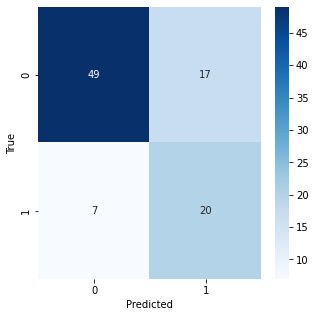

In [130]:
y_predict_decision_tree = decision_tree.predict(test)
cm_decision_tree = confusion_matrix(target_test, y_predict_decision_tree)
plt.figure(figsize=(5,5))
sns.heatmap(cm_decision_tree, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [131]:
print(classification_report(target_test, y_predict_decision_tree))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80        66
           1       0.54      0.74      0.62        27

    accuracy                           0.74        93
   macro avg       0.71      0.74      0.71        93
weighted avg       0.78      0.74      0.75        93



### Random Forests

*Random* Forests is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 700]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [37]:
RF_param_grid={
        'criterion': ['gini', 'entropy'],
        'class_weight': ['balanced', 'balanced_subsample'],
        'n_estimators': range(100,700,10),
}

In [38]:
# Random Forest

random_forest = GridSearchCV(RandomForestClassifier(), RF_param_grid).fit(train, target)


In [39]:
acc_random_forest = random_forest.score(train, target)
acc_test_random_forest = random_forest.score(test, target_test)

print("acc_random_forest_train_accuracy = ",acc_random_forest)
print("Random forest best params: ", random_forest.best_params_)
print("acc_test_random_forest_test_accuracy = ",acc_test_random_forest)

acc_random_forest_train_accuracy =  1.0
Random forest best params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 100}
acc_test_random_forest_test_accuracy =  0.8064516129032258


Text(24.0, 0.5, 'True')

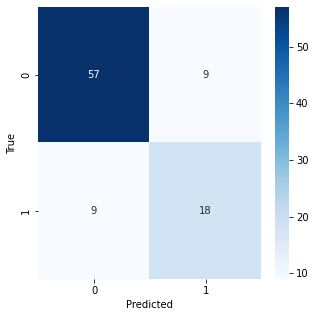

In [132]:
y_predict_random_forest = random_forest.predict(test)
cm_random_forest = confusion_matrix(target_test, y_predict_random_forest)
plt.figure(figsize=(5,5))
sns.heatmap(cm_random_forest, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [133]:
print(classification_report(target_test, y_predict_decision_tree))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80        66
           1       0.54      0.74      0.62        27

    accuracy                           0.74        93
   macro avg       0.71      0.74      0.71        93
weighted avg       0.78      0.74      0.75        93



### XGB Classifier 

XGBoost is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements

In [134]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.8294372294372294
{'booster': 'gbtree', 'colsample_bytree': 0.8200000000000001, 'eta': 0.365, 'eval_metric': 'auc', 'gamma': 0.765, 'learning_rate': 0.0329, 'max_depth': 2, 'min_child_weight': 4.575, 'missing': None, 'n_estimators': 165, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.6950000000000001, 'tree_method': 'exact'}
0.8155844155844155
{'booster': 'gbtree', 'colsample_bytree': 0.995, 'eta': 0.41000000000000003, 'eval_metric': 'auc', 'gamma': 0.53, 'learning_rate': 0.046400000000000004, 'max_depth': 2, 'min_child_weight': 8.025, 'missing': None, 'n_estimators': 990, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8300000000000001, 'tree_method': 'exact'}
0.811038961038961
{'booster': 'gbtree', 'colsample_bytree': 0.715, 'eta': 0.09, 'eval_metric': 'auc', 'gamma': 0.735, 'learning_rate': 0.037000000000000005, 'max_depth': 6, 'min_child_weight': 8.1, 'missing': None, 'n_estimators': 282, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.94000000

In [41]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.91,
 'eta': 0.425,
 'eval_metric': 'auc',
 'gamma': 0.92,
 'learning_rate': 0.0362,
 'max_depth': 5,
 'min_child_weight': 8.175,
 'missing': None,
 'n_estimators': 202,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.595,
 'tree_method': 'exact'}

In [42]:
XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(train, target)
acc_XGB_Classifier = XGB_Classifier.score(train, target)
acc_test_XGB_Classifier = XGB_Classifier.score(test, target_test)

print("acc_XGB_Classifier_train_accuracy = ",acc_XGB_Classifier)
print("acc_test_XGB_Classifier_test_accuracy = ",acc_test_XGB_Classifier)

acc_XGB_Classifier_train_accuracy =  0.8341013824884793
acc_test_XGB_Classifier_test_accuracy =  0.8817204301075269


Text(24.0, 0.5, 'True')

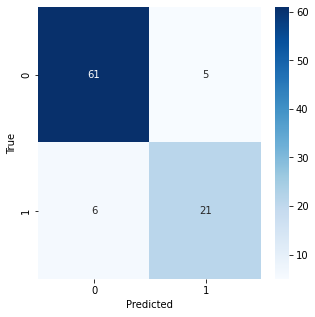

In [135]:
y_predict_XGB = XGB_Classifier.predict(test)
cm_XGB = confusion_matrix(target_test, y_predict_XGB)
plt.figure(figsize=(5,5))
sns.heatmap(cm_XGB, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [136]:
print(classification_report(target_test, y_predict_XGB))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        66
           1       0.81      0.78      0.79        27

    accuracy                           0.88        93
   macro avg       0.86      0.85      0.85        93
weighted avg       0.88      0.88      0.88        93



### LGBM Classifier 

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’

We will tuning the hyperparameters of the LGBMClassifier model using the HyperOpt and 10-fold crossvalidation



In [44]:
def hyperopt_lgb_score(params):
    clf = LGBMClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_lgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'num_leaves': hp.choice('num_leaves', 2*np.arange(2, 2**11, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.8248917748917748
{'boosting_type': 'gbdt', 'colsample_bytree': 0.9450000000000001, 'learning_rate': 0.024300000000000002, 'max_depth': 7, 'min_child_weight': 7.075, 'n_estimators': 392, 'num_leaves': 1698, 'objective': 'binary'}
0.8298701298701298
{'boosting_type': 'gbdt', 'colsample_bytree': 0.71, 'learning_rate': 0.0466, 'max_depth': 4, 'min_child_weight': 4.375, 'n_estimators': 544, 'num_leaves': 3770, 'objective': 'binary'}
0.8478354978354978
{'boosting_type': 'gbdt', 'colsample_bytree': 0.63, 'learning_rate': 0.0068000000000000005, 'max_depth': 11, 'min_child_weight': 5.95, 'n_estimators': 442, 'num_leaves': 1724, 'objective': 'binary'}
0.8525974025974026
{'boosting_type': 'gbdt', 'colsample_bytree': 0.55, 'learning_rate': 0.018500000000000003, 'max_depth': 3, 'min_child_weight': 3.5, 'n_estimators': 506, 'num_leaves': 586, 'objective': 'binary'}
0.8389610389610389
{'boosting_type': 'gbdt', 'colsample_bytree': 0.735, 'learning_rate': 0.0368, 'max_depth': 3, 'min_child_weight': 4

In [45]:
params = space_eval(space_lgb, best)
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.87,
 'learning_rate': 0.0012000000000000001,
 'max_depth': 9,
 'min_child_weight': 4.525,
 'n_estimators': 790,
 'num_leaves': 686,
 'objective': 'binary'}

In [46]:
LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(train, target)
acc_LGB_Classifier = LGB_Classifier.score(train, target)
acc_test_LGB_Classifier = LGB_Classifier.score(test, target_test)

print("acc_LGB_Classifier_train_accuracy = ",acc_LGB_Classifier)
print("acc_test_LGB_Classifier_test_accuracy = ",acc_test_LGB_Classifier)

acc_LGB_Classifier_train_accuracy =  0.8986175115207373
acc_test_LGB_Classifier_test_accuracy =  0.8709677419354839


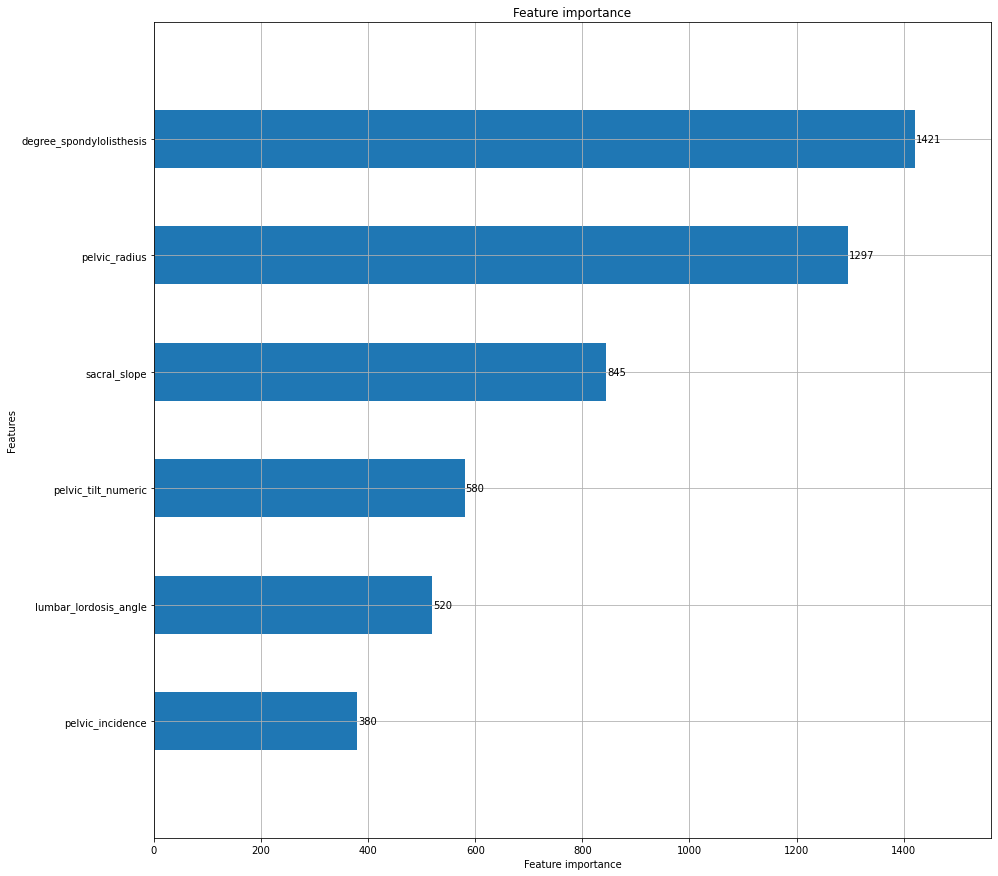

In [47]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(LGB_Classifier,ax = axes,height = 0.5)
plt.show();
plt.close()

### ExtraTreesClassifier 

ExtraTreesClassifier implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference sklearn documentation.

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

In [51]:
def hyperopt_etc_score(params):
    clf = ExtraTreesClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_etc = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_features': hp.choice('max_features', np.arange(2, 17, dtype=int)),
            'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5, dtype=int)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'max_features': None # for small number of features
        }
 
best = fmin(fn=hyperopt_etc_score, space=space_etc, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.8803030303030303
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'n_estimators': 571}
0.8383116883116883
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 236}
0.8575757575757574
{'max_depth': 11, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 889}
0.8662337662337662
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'n_estimators': 881}
0.8755411255411255
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 817}
0.8755411255411255
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 574}
0.870995670995671
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 304}
0.8757575757575757
{'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 722}
0.88008658008658
{'max_depth': 11, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 391}
0.8705627705627705
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3,

In [52]:
params = space_eval(space_etc, best)
params

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'n_estimators': 236}

In [53]:
# Extra Trees Classifier

extra_trees_classifier = ExtraTreesClassifier(**params)
extra_trees_classifier.fit(train, target)
acc_etc = extra_trees_classifier.score(train, target)
acc_test_etc = extra_trees_classifier.score(test, target_test)

print("acc_etc_accuracy = ",acc_etc)
print("acc_test_etc_train_accuracy = ",acc_test_etc)

acc_etc_accuracy =  0.9447004608294931
acc_test_etc_train_accuracy =  0.8279569892473119


Text(24.0, 0.5, 'True')

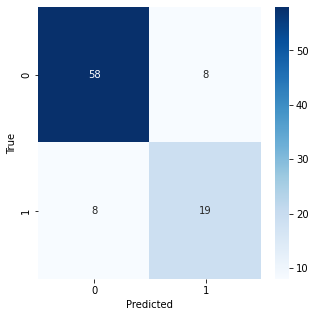

In [137]:
y_predict_Extra_Trees = extra_trees_classifier.predict(test)
cm_Extra_Trees = confusion_matrix(target_test, y_predict_Extra_Trees)
plt.figure(figsize=(5,5))
sns.heatmap(cm_Extra_Trees, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [138]:
print(classification_report(target_test, y_predict_Extra_Trees))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        66
           1       0.70      0.70      0.70        27

    accuracy                           0.83        93
   macro avg       0.79      0.79      0.79        93
weighted avg       0.83      0.83      0.83        93



### Neural Network 1

Neural networks are more complex and more powerful algorithm than standars machine learning, it belongs to deep learning models. To build a neural network use Keras. Keras is a high level API for tensorflow, which is a tensor-manipulation framework made by google. Keras allows you to build neural networks by assembling blocks (which are the layers of neural network).



In [54]:
def build_ann(optimizer='adam'):
    
    # Initializing the ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of the ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(len(train.columns),)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [55]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
# Training the ANN
history = ann.fit(Xtrain, Ztrain, batch_size=16, epochs=100, validation_data=(Xval, Zval))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - 1s 26ms/step - loss: 7.3104 - accuracy: 0.5166 - val_loss: 2.2281 - val_accuracy: 0.6818
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 5.0890 - accuracy: 0.6424 - val_loss: 2.6505 - val_accuracy: 0.6818
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 4.4045 - accuracy: 0.5629 - val_loss: 1.7978 - val_accuracy: 0.6818
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 3.4563 - accuracy: 0.5629 - val_loss: 1.1305 - val_accuracy: 0.6818
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 3.0694 - accuracy: 0.5960 - val_loss: 0.9932 - val_accuracy: 0.6818
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 2.3493 - accuracy: 0.6291 - val_loss: 0.9775 - val_accuracy: 0.6818
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 1.6787 - accuracy: 0.7020 - val_loss: 0.6951 - val_accuracy: 0.6667
Epoch 8/100


In [56]:
# Predicting the Train set results
ann_prediction = ann.predict(train)
ann_prediction = (ann_prediction > 0.5)*1 


acc_ann1 = metrics.accuracy_score(target, ann_prediction)

ann_prediction_test = ann.predict(test)
ann_prediction_test = (ann_prediction_test > 0.5)*1 

acc_test_ann1 = metrics.accuracy_score(target_test, ann_prediction_test)

print("acc_ann1_accuracy = ",acc_ann1)
print("acc_test_ann1_train_accuracy = ",acc_test_ann1)

3/3 [==============================] - 0s 3ms/step
acc_ann1_accuracy =  0.8202764976958525
acc_test_ann1_train_accuracy =  0.8279569892473119


## Models evaluation 

In [144]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 'k-Nearest Neighbors', 'Naive Bayes', 
              'Decision Tree Classifier', 'Random Forest',  'XGBClassifier', 'LGBMClassifier',
              'ExtraTreesClassifier', 'Neural Network 1'],
    
    'Score_train': [acc_log, acc_svc, acc_linear_svc, acc_knn, acc_gaussian, 
              acc_decision_tree, acc_random_forest, acc_XGB_Classifier, acc_LGB_Classifier,acc_etc,acc_ann1],
    'Score_test': [acc_test_log, acc_test_svc, acc_test_linear_svc, acc_test_knn, acc_test_gaussian, 
              acc_test_decision_tree, acc_test_random_forest, acc_test_XGB_Classifier, acc_test_LGB_Classifier,
              acc_test_etc, acc_test_ann1]
                    })

In [149]:
models.sort_values(by=['Score_train', 'Score_test'], ascending=True)

,Model,Score_train,Score_test
4,Naive Bayes,0.769585,0.817204
10,Neural Network 1,0.820276,0.827957
7,XGBClassifier,0.834101,0.881720
2,Linear SVC,0.847926,0.860215
0,Logistic Regression,0.847926,0.870968
1,Support Vector Machines,0.857143,0.870968
5,Decision Tree Classifier,0.898618,0.741935
8,LGBMClassifier,0.898618,0.870968
9,ExtraTreesClassifier,0.944700,0.827957
6,Random Forest,1.000000,0.806452


In [63]:
models['Score_diff'] = abs(models['Score_train'] - models['Score_test'])
models.sort_values(by=['Score_diff'], ascending=True)

,Model,Score_train,Score_test,Score_diff
1,Support Vector Machines,0.843318,0.849462,0.006144
11,Neural Network 1,0.820276,0.827957,0.007680
2,Linear SVC,0.847926,0.860215,0.012289
0,Logistic Regression,0.847926,0.870968,0.023041
8,LGBMClassifier,0.898618,0.870968,0.027650
12,AdaBoostClassifier,0.852535,0.817204,0.035330
7,XGBClassifier,0.834101,0.881720,0.047619
4,Naive Bayes,0.769585,0.817204,0.047619
10,ExtraTreesClassifier,0.944700,0.827957,0.116743
5,Decision Tree Classifier,0.898618,0.741935,0.156682


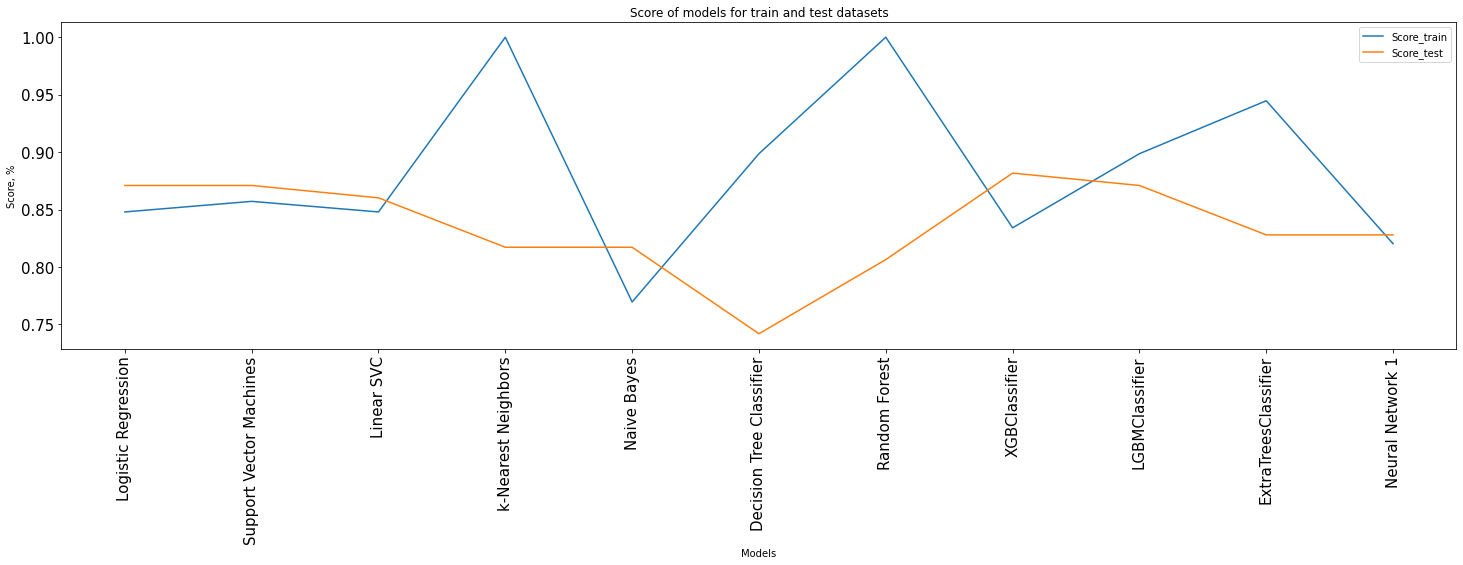

In [156]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=15)
plt.plot(xx, models['Score_train'], label = 'Score_train')
plt.plot(xx, models['Score_test'], label = 'Score_test')
plt.legend()
plt.title('Score of models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Score, %')
plt.xticks(xx, rotation='vertical')
plt.savefig("comparision")
plt.show()

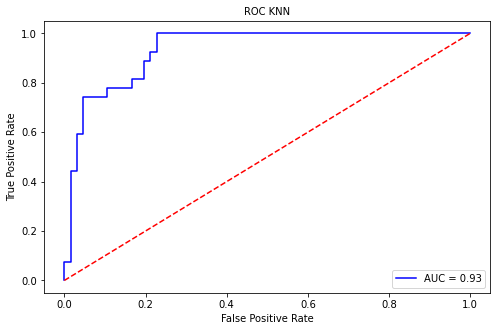

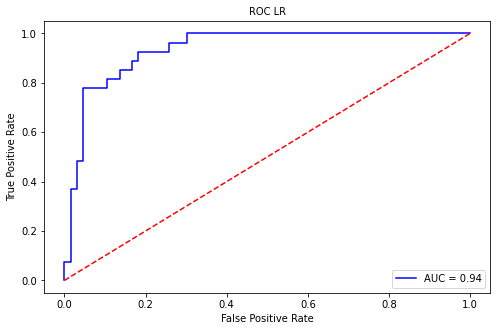

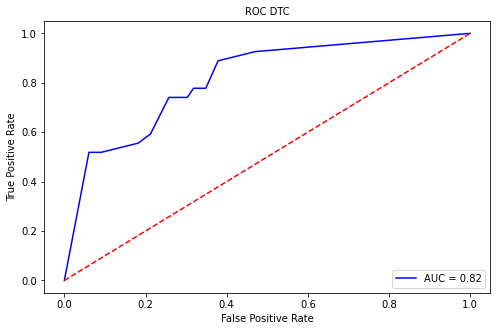

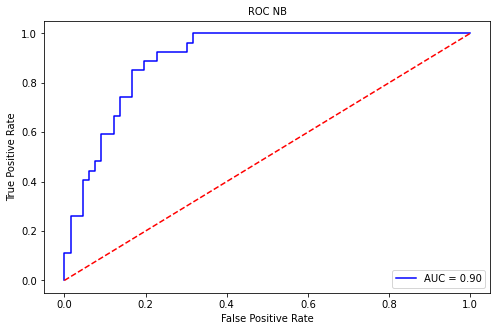

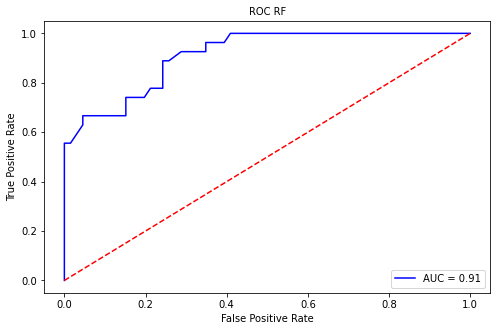

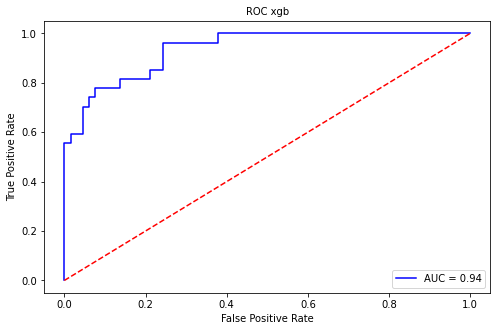

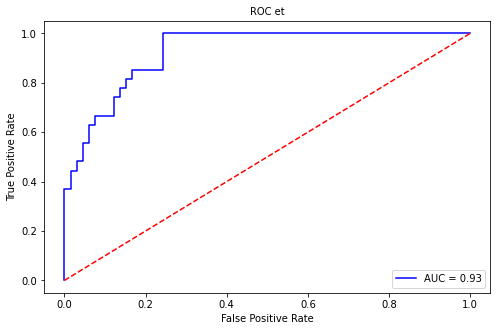

In [169]:
prob_knn = knn.predict_proba(test)[:,1]
prob_lr = logreg_model.predict_proba(test)[:,1]
prob_dtc = decision_tree.predict_proba(test)[:,1]
prob_NB = gaussian.predict_proba(test)[:,1]
prob_rf = random_forest.predict_proba(test)[:,1]
prob_xgb = XGB_Classifier.predict_proba(test)[:,1]
prob_et = extra_trees_classifier.predict_proba(test)[:,1]

prob_dict = {"ROC KNN": prob_knn, "ROC LR": prob_lr, "ROC DTC": prob_dtc, 
             "ROC NB": prob_NB, "ROC RF": prob_rf,  "ROC xgb": prob_xgb, "ROC et": prob_et,}

for model, prob in prob_dict.items():
    fpr, tpr, threshold = metrics.roc_curve(target_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(8,5))
    plt.plot(fpr, tpr, color = "b", label = "AUC = %0.2f" %roc_auc)
    plt.legend(loc="lower right", prop={"size":10})
    plt.xlabel("False Positive Rate", size=10)
    plt.ylabel("True Positive Rate", size=10)
    plt.plot([0,1], [0,1], "r--")
    plt.title(str(model), size=10)